In [0]:
%%bash

# install edgetpu_compiler
echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB

sudo apt update > /dev/null
sudo apt install edgetpu > /dev/null

# install tensorflow 2.0
pip install tensorflow-gpu==2.0-beta1

deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Executing: /tmp/apt-key-gpghome.xLwbjpgTJz/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB


gpg: key 6A030B21BA07F4FB: "Google Cloud Packages Automatic Signing Key <gc-team@google.com>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1






## Build CNN AutoEncoder with Keras

In [1]:
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt


print(f'TensorFlow\'s version: {tf.__version__}')

/home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

TensorFlow's version: 2.0.0-beta1


/home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

In this notebook we use Fashion MNIST

In [37]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.dtype)
print(train_images.shape)
print(test_images.dtype)
print(test_images.shape)

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images[:, :, :, np.newaxis].astype(np.float32)
test_images = test_images[:, :, :, np.newaxis].astype(np.float32)

uint8
(60000, 28, 28)
uint8
(10000, 28, 28)


Build Model

In [3]:
# UpSampling2D (using nearest neighber) is not supported yet.
# We should implement it by myself.
def UpSampling2D(scale=(2, 2)):
    if isinstance(scale, int):
        scale = (scale, scale)

    def upsampling(x):
        shape = x.shape
        x = keras.layers.Concatenate(-2)([x]*scale[0])
        x = keras.layers.Reshape([shape[1]*scale[0], shape[2], shape[3]])(x)
        x = keras.layers.Concatenate(-1)([x]*scale[1])
        x = keras.layers.Reshape([shape[1]*scale[0], shape[2]*scale[1], shape[3]])(x)
        return x
    
    return upsampling

In [4]:
def build_keras_model(hidden_size=2):
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(hidden_size)(x)
    
    x = layers.Dense(7*7*8)(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((7, 7, 8))(x)
    x = UpSampling2D()(x)
    # x = layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = layers.Conv2D(8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = UpSampling2D()(x)
    # x = layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [5]:
model = build_keras_model()
model.summary()
model.fit(train_images, train_images, epochs=1)
model.save('model.h5')

W0805 20:02:16.452505 140428756795520 deprecation.py:323] From /home/maka/.pyenv/versions/3.6.8/envs/deep-learning/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

We need small dataset to calibrate quantization parameters.

In [61]:
cifar100 = keras.datasets.cifar100


(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.dtype)
print(train_images.shape)
print(test_images.dtype)
print(test_images.shape)

float64
(50000, 32, 32, 3)
float64
(10000, 32, 32, 3)


In [82]:
class_names = np.array([
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
])
def display(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)
    plt.show()
import time 
def compile_(model):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

def test(model):
    now = time.time()
    test_loss, test_acc = basic_model.evaluate(test_images, test_labels)
    elapsed = time.time() - now
    print('[%.3fs] Test accuracy: %s' % (elapsed, test_acc))

def predict(model):
    now = time.time()
    model.predict(test_images)
    elapsed = time.time() - now
    return elapsed

def time_predict(model, times):
    predict_times = [predict(model) for _ in range(10)]
    mean = (sum(predict_times) - min(predict_times) - max(predict_times)) / (len(predict_times) - 2)
    print('Prediction Timing: %.3fs' % mean)

def fit(model, epochs_=1, initial_epoch=0):
    model.fit(x=train_images, y=train_labels, epochs=epochs_, initial_epoch=initial_epoch)

def save(model, name, epochs_):
    filename = name + '_%03d.h5' % epochs_
    print('Saving %s...' % filename)
    model.save(filename)

def train(name, model, epochs_, initial_epoch=0):
    for i in range(initial_epoch + 1, epochs_ + 1):
        label = str(i) + ' ' + name
        print('~~~~~~~~~~~~~~~~~~~~ ', label, ' ~~~~~~~~~~~~~~~~~~~~', sep='')
        
        # fit
        fit(model, i, initial_epoch=i-1)
        
        # predict
        time_predict(model, 5)

        # test
        test(model)
        
        # save
        save(model, name, i)
        print('~~~~~~~~~~~~~~~~~~~~ ', '/end '.ljust(len(label) + 1, '='), '~~~~~~~~~~~~~~~~~~~~', sep='')
        print()

In [63]:
basic_model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(class_names), activation=tf.nn.softmax)
])
basic_model.summary()
compile_(basic_model)
fit(basic_model, 1)
test(basic_model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               12900     
Total params: 406,244
Trainable params: 406,244
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples
10000/10000 [==============================] - 1s 54us/sample - loss: 4.3188 - accuracy: 0.0260
[0.580s] Test accuracy: 0.026


In [117]:
def representative_dataset_gen():
    for i in range(1000):
        result = train_images[i: i + 1].astype(np.float32)
        yield [result]
        

# Currentry, it seems that tf.lite.TFLiteConverter does not suppert inference_input/output_type yet.
# So we have to use tf.compat.v1.lite.TFLiteConverter.
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('resnet50_001.h5')
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open('model.tflite', 'wb') as o_:
    o_.write(tflite_model)
    
    
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# tflite_model = converter.convert()

# with open('model.tflite', 'wb') as o_:
#     o_.write(tflite_model)

I0805 20:50:09.696093 140428756795520 convert_to_constants.py:238] Converted 320 variables to const ops.


We can validate the tflite model using tf.lite.Interpreter.

In [118]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
#input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.uint8)
now = time.time()
for _ in range(1):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()



    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
print(time.time() - now)

now = time.time()
basic_model.predict(test_images[:1])
print(time.time() - now)

0.30313634872436523
0.01671123504638672


In [102]:
def quantize(real_value):
    std, mean = input_detail['quantization']
    return (real_value/std + mean).astype(np.uint8)


#interpreter.allocate_tensors()
input_ = interpreter.tensor(interpreter.get_input_details()[0]["index"])
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])
for i in range(10):
    input_().fill(3.)
    interpreter.invoke()
    print("inference %s" % output())

sample_input = quantize(test_images)
print(sample_input[0])

interpreter.set_tensor(input_detail['index'], sample_input)
interpreter.invoke()

[[[198 214 248]
  [195 210 243]
  [194 209 242]
  ...
  [215 230 249]
  [216 230 249]
  [223 233 251]]

 [[196 209 238]
  [194 207 237]
  [194 209 239]
  ...
  [230 242 249]
  [232 242 249]
  [240 244 252]]

 [[221 225 245]
  [212 219 241]
  [208 218 242]
  ...
  [242 249 250]
  [243 248 250]
  [249 249 252]]

 ...

 [[ 71  72  98]
  [ 70  73 101]
  [ 73  77 107]
  ...
  [219 207 216]
  [182 167 180]
  [154 140 149]]

 [[ 71  74 103]
  [ 75  80 110]
  [ 83  88 121]
  ...
  [221 211 219]
  [186 173 191]
  [144 131 148]]

 [[ 79  84 117]
  [ 83  89 122]
  [ 84  91 126]
  ...
  [216 206 214]
  [206 193 210]
  [175 163 182]]]


RuntimeError: There is at least 1 reference to internal data
      in the interpreter in the form of a numpy array or slice. Be sure to
      only hold the function returned from tensor() if you are using raw
      data access.

[{'name': 'flatten_input', 'index': 8, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0)}]
[{'name': 'Identity', 'index': 9, 'shape': array([  1, 100], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0)}]
[{'name': 'Identity', 'index': 9, 'shape': array([  1, 100], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0)}]


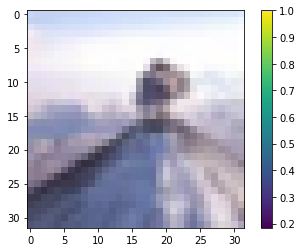

(32, 32, 3)
[49]
(1, 32, 32, 3)
plain
[[8.77413608e-04 4.37755743e-03 2.26805243e-03 6.87796855e-03
  6.71930145e-03 1.16651002e-02 1.37637649e-03 2.30081868e-03
  9.86437872e-03 7.54444953e-03 6.22065226e-03 5.13636181e-03
  2.62515768e-02 1.96711589e-02 1.32081716e-03 1.73578821e-02
  2.42905947e-03 5.37013523e-02 4.94780764e-03 1.53299384e-02
  2.80757621e-03 8.11393932e-03 6.19577290e-03 1.77304614e-02
  2.31868890e-03 1.69448089e-02 2.45091785e-03 6.20003743e-03
  3.14367213e-03 6.92004245e-03 3.56732286e-03 1.12142731e-02
  2.12131571e-02 1.77665297e-02 1.32757402e-03 2.95896037e-03
  2.26460863e-03 2.93512456e-02 2.12090136e-03 1.00549953e-02
  1.18680308e-02 1.35544455e-02 3.88921704e-03 9.38796613e-04
  3.00852838e-03 2.56824796e-03 1.52746579e-02 3.42156403e-02
  1.09328888e-02 1.10569801e-02 1.57715171e-03 4.40639630e-03
  1.44731952e-02 4.94472588e-05 3.40132532e-03 9.67041682e-03
  1.34621644e-02 2.77635595e-03 2.24555898e-02 1.60455406e-02
  6.01551645e-02 1.95857347e-03 

In [91]:
original_image = test_images[0]
display(original_image)
print(test_images[0].shape)
print(test_labels[0])
print(test_images[:1].shape)

pred_original_model = basic_model.predict(test_images[:1])
print(class_names[np.argmax(pred_original_model)])
print(pred_original_model)

pred_quantized_model =  interpreter.get_tensor(output_detail['index'])
print(class_names[np.argmax(pred_quantized_model)])
print(pred_quantized_model)

print(class_names)

In [86]:

def predict(model):
    now = time.time()
    model.predict(test_images)
    elapsed = time.time() - now
    return elapsed

def time_predict(model, times=5):
    predict_times = [predict(model) for _ in range(10)]
    mean = (sum(predict_times) - min(predict_times) - max(predict_times)) / (len(predict_times) - 2)
    print('Prediction Timing: %.3fs' % mean)
    
time_predict(basic_model)

Prediction Timing: 0.493s


In [0]:
%%bash

edgetpu_compiler --show_operations 'model.tflite'

Edge TPU Compiler version 1.0.249710469

Model compiled successfully in 89 ms.

Input model: model.tflite
Input size: 15.63KiB
Output model: model_edgetpu.tflite
Output size: 132.55KiB
On-chip memory available for caching model parameters: 7.82MiB
On-chip memory used for caching model parameters: 57.50KiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 22
Operation log: model_edgetpu.log

Operator                       Count      Status

CONCATENATION                  4          Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
CONV_2D                        5          Mapped to Edge TPU
DEPTHWISE_CONV_2D              1          Mapped to Edge TPU
RESHAPE                        5          Mapped to Edge TPU
FULLY_CONNECTED                2          Mapped to Edge TPU
LOGISTIC                       1          Mapped to Edge TPU
MAX_POOL_2D                    2          Mapped to

INFO: Initialized TensorFlow Lite runtime.


In [0]:
from google.colab import files

files.download('model_edgetpu.tflite')